<a href="https://colab.research.google.com/github/thaCripple/Simple-Machine-Learning/blob/main/Stacking%20Classifier/Stacking_Classifier_trial_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Stacking Classifier Implementation</h1>



## Loading the Wine Classification dataset from sklearn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
sns.set_style(style="whitegrid")

In [2]:
from sklearn.datasets import load_wine

In [159]:
X, y = load_wine(return_X_y=True, as_frame=True)

In [160]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

<h3>Checking whether classes are imbalanced</h3>

In [8]:
y.value_counts()

,count
target,
1,71
0,59
2,48


## Reducing data set dimensionality

<h3>Splitting the data into training and testing subsets</h3>
<p>Not sure if this split is necessary to avoid cross-contaminating the testing and training sets.

I don't think so, since this classifier doesn't modify the data nor does it have any impact on the classifiers later on</p>

In [9]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

<h2>Assesing feature importance using the Random Forest Classifier</h2>

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [13]:
forest1 = RandomForestClassifier(n_estimators=200, max_depth=2, min_samples_leaf=4)

In [15]:
forest1.fit(X=X_train, y=y_train)

RandomForestClassifier(max_depth=2, min_samples_leaf=4, n_estimators=200)

In [16]:
forest1.feature_importances_

array([0.1031283 , 0.0347168 , 0.00881371, 0.03372419, 0.01737964,
       0.06499755, 0.19099189, 0.00650693, 0.01273881, 0.14059635,
       0.08468777, 0.12708951, 0.17462854])

In [24]:
importances_df = pd.DataFrame(data=forest1.feature_importances_, columns=["Importance"], index=X_train.columns)
importances_df.sort_values(by="Importance", ascending=False, inplace=True)

<h3>Visualizing the impact of each feature</h3>

[Text(31.87530864197531, 0.5, 'Feature')]

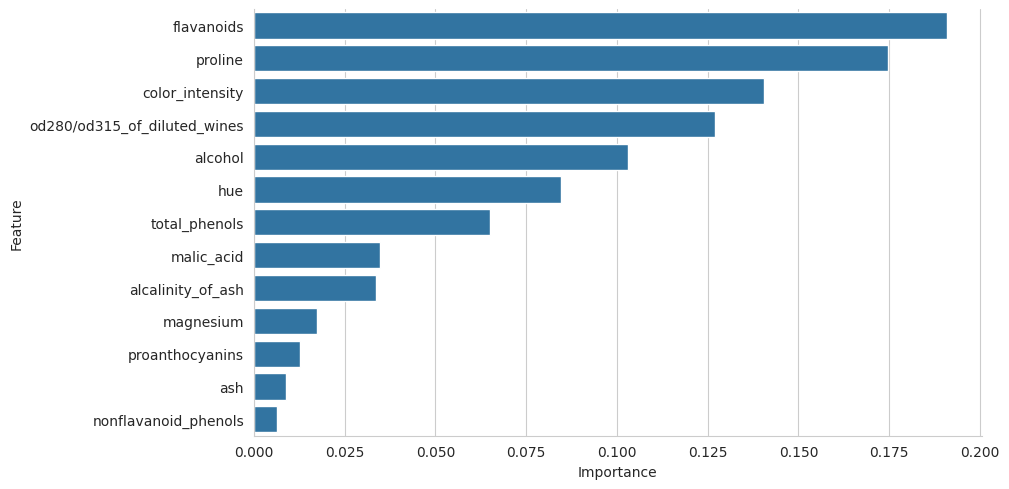

In [60]:
importances_plt1 = sns.catplot(kind="bar", data=importances_df, y=importances_df.index, x="Importance", aspect=2)
importances_plt1.ax.set(ylabel="Feature")

<h2>Creating a new subset of the training data comprising the top 4 most impactful features</h2>

In [33]:
top4_features = ["flavanoids", "proline", "color_intensity", "od280/od315_of_diluted_wines"]

In [34]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

In [50]:
X = X.loc[:,top4_features]
# Change the name of "od280/od315_of_diluted_wines" to someting more sensible
X.rename(columns={"od280/od315_of_diluted_wines": "protein"}, inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   flavanoids       178 non-null    float64
 1   proline          178 non-null    float64
 2   color_intensity  178 non-null    float64
 3   protein          178 non-null    float64
dtypes: float64(4)
memory usage: 5.7 KB


<h3>Merging the Feature and Label Data Frames into one to visualize class boundaries</h3>

In [55]:
important_features_df = pd.concat([X, y], axis=1)
important_features_df.head()

,flavanoids,proline,color_intensity,protein,target
0,3.06,1065.0,5.64,3.92,0
1,2.76,1050.0,4.38,3.40,0
2,3.24,1185.0,5.68,3.17,0
3,3.49,1480.0,7.80,3.45,0
4,2.69,735.0,4.32,2.93,0


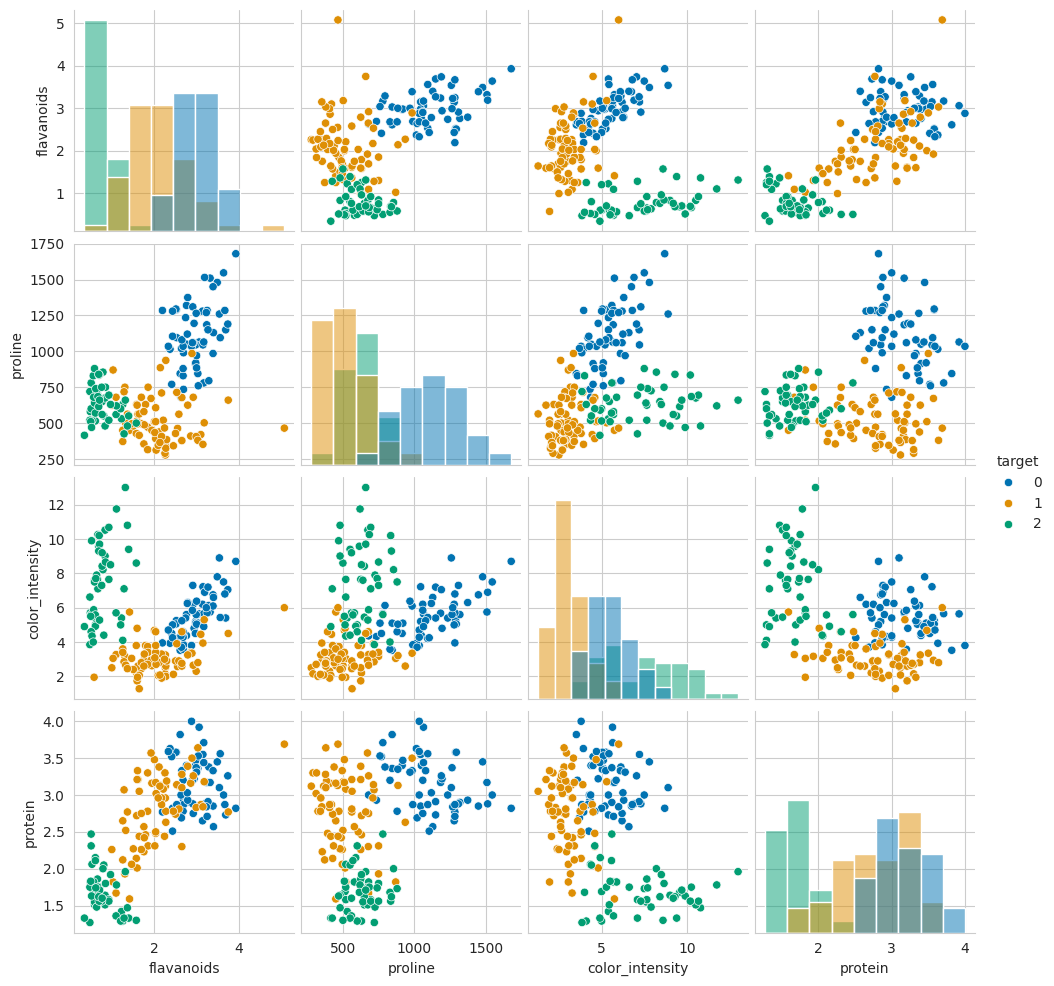

In [61]:
sns.pairplot(diag_kind="hist", data=important_features_df, hue="target", palette="colorblind")

## Implementing the Stacking Classifier

<h3>Performing a new train test split on the slimmed down data with a different random state</h3>

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

In [52]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124 entries, 99 to 168
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   flavanoids       124 non-null    float64
 1   proline          124 non-null    float64
 2   color_intensity  124 non-null    float64
 3   protein          124 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [63]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

<h3>The Stacking Classifier will contain:</h3>


1.   First Layer:
  1.  Histogram-Based Gradient Boosting Classifier
  2.  Support Vector Machine Classifier
2.   Logistic Regression Classifier as the final estimator



<p>Creating a Pipeline for the SVM Classifier that will scale and normalize the data, then perform a Grid Search Cross Validation to determine the best Hyper Parameters</p>

In [129]:
svc1 = SVC()
grid1_params = {
    "C": [1, 10, 100],
    "gamma": [.01, .1, 1]
    }

In [130]:
grid1 = GridSearchCV(estimator=svc1, param_grid=grid1_params, n_jobs=-1)

In [131]:
pipe1 = Pipeline(steps=[
    ("scaler", RobustScaler()),
    ("SVC", grid1)
])

In [132]:
estimators = [
    ("HGBC", HistGradientBoostingClassifier(min_samples_leaf=4)),
    ("SVC", pipe1)
    ]

<p> Constructing the Stacking Classifier</p>

In [133]:
stack1 = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(n_jobs=-1), n_jobs=-1)

In [134]:
stack1.fit(X=X_train, y=y_train)

StackingClassifier(estimators=[('HGBC',
                                HistGradientBoostingClassifier(min_samples_leaf=4)),
                               ('SVC',
                                Pipeline(steps=[('scaler', RobustScaler()),
                                                ('SVC',
                                                 GridSearchCV(estimator=SVC(),
                                                              n_jobs=-1,
                                                              param_grid={'C': [1,
                                                                                10,
                                                                                100],
                                                                          'gamma': [0.01,
                                                                                    0.1,
                                                                                    1]}))]))],
                   final_estimator=LogisticRegression(n_jobs=-1), n_jobs=-1)

In [135]:
stack1_predictions = stack1.predict(X=X_test)

In [136]:
from sklearn.metrics import classification_report, f1_score

<h3>Scores achieved by the Stacking Classifier</h3>

In [137]:
print(classification_report(y_true=y_test, y_pred=stack1_predictions))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.91      1.00      0.95        20
           2       1.00      1.00      1.00        14

    accuracy                           0.96        54
   macro avg       0.97      0.97      0.97        54
weighted avg       0.97      0.96      0.96        54



<p>Getting just the F1 Score and storing it in a dictionary for later</p>

In [138]:
stack1_f1 = f1_score(y_test, stack1_predictions, average="weighted")
stack1_f1

0.9628701383087348

In [139]:
f1_scores = {"Stack": stack1_f1}

## Assessing the performance of the same classifiers individualy

<h3>Instantiating new classifiers with the same parameters</h3>

In [140]:
svc2 = SVC()
grid2_params = {
    "C": [1, 10, 100],
    "gamma": [.01, .1, 1]
    }

In [141]:
grid2 = GridSearchCV(estimator=svc2, param_grid=grid2_params, n_jobs=-1)

In [142]:
pipe2 = Pipeline(steps=[
    ("scaler", RobustScaler()),
    ("SVC", grid2)
])

In [143]:
hgbc2 = HistGradientBoostingClassifier(min_samples_leaf=4)

In [144]:
classifiers = [pipe2, hgbc2]

Running a neat `for` loop to fit each classifier and store their F1 scores in the dictionary from before







In [145]:
for classifier_name, classifier in zip(["SVC Grid", "HGBC"], classifiers):
  classifier.fit(X=X_train, y=y_train)
  score = f1_score(y_true=y_test, y_pred=classifier.predict(X=X_test), average="weighted")
  f1_scores[classifier_name] = score


In [157]:
grid2.best_params_

{'C': 100, 'gamma': 0.01}

<h3>Visualizing the F1 Score achieved by each classifier individualy and the entire Stack</h3>

In [151]:
f1_scores_srs = pd.Series(data=f1_scores, name="F1 Score")
f1_scores_srs

,F1 Score
Stack,0.962870
SVC Grid,0.962870
HGBC,0.870687


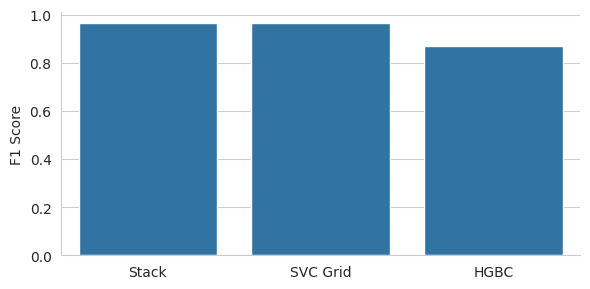

In [154]:
sns.catplot(kind="bar", data=f1_scores_srs, height=3, aspect=2)

## Conclusions

<p>For this data set the Stacking Classifier performed as well as the Support Vector Classifier on it's own.<br>
This suggests that the Histogram Gradient Boosted Trees Classifier was not a good choice for this problem.<br>
It also underlines the importance of selecting classifiers appropriate to a given problem and that complement each other, in order to reap the benefits of the increased computation cost associated with the Stacking Classifier.</p>